# Experiment One

The second study, called `experiment-one`, looked at the effect of social influence on curiousity, using upvotes as proxy for social interest. Below we analyze the responses to test the hypothesis that the same questions, when given higher upvotes, receive higher scores from participants with regards to curiousity. And, further, whether this translates into participants being more likely to choose to view the answers to the questions with higher upvotes.

## Analysis

In [1]:
%load_ext pycodestyle_magic

In [26]:
# Analytical Tools
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.stats.api as sms

# General Utilities
import math
import json
import pprint
import itertools
import importlib

# Custom Utilities
import utilities.processing_one as processing
import utilities.plotting as plotting
import utilities.describe as describe

# Some settings
from IPython.display import Markdown, display
log = pprint.pprint
space = lambda: print()
printmd = lambda text: display(Markdown(text))
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Reading Data and Defining Constants

In [3]:
FILE_NAMES = [
    'raw-data/responses-one.json'
]

NUM_QUESTIONS, NUM_JUDGEMENTS = 10, 2
GROUP_SIZE = NUM_QUESTIONS // 2

ALL_LABELS = processing.get_all_labels(NUM_QUESTIONS)
LOW_LABELS, HIGH_LABELS = ALL_LABELS[:GROUP_SIZE], ALL_LABELS[GROUP_SIZE:]
JUDGMENT_LABELS = processing.get_judgment_labels(NUM_JUDGEMENTS)

with open(FILE_NAMES[0]) as file:
    master_responses = [json.loads(line) for line in file if line]

### Reading Responses into Data
Creates a `DataFrame` based on the survey data.

In [4]:
col_labels = processing.get_col_labels(NUM_QUESTIONS,
                                       NUM_JUDGEMENTS)
data = {label: [] for label in col_labels}

In [5]:
processing.fill_experiment_data(data, master_responses)
master_responses[0]['data'][3]

{'internal_node_id': '0.0-3.0-0.0',
 'judgmentIndicies': [0, 1],
 'questionIndicies': [4, 27, 10, 44, 40, 45, 12, 17, 3, 24],
 'questionScores': [27, 24, 2402, 34, 22, 2398, 2405, 2407, 2401, 23],
 'responses': '{"Q0":"4","Q1":"5"}',
 'rt': 5381,
 'time_elapsed': 13133,
 'trial_index': 3,
 'trial_type': 'survey-likert'}

In [6]:
data = pd.DataFrame(data)
data = data[data.consent == 1]
sample_size = len(data)
print(data.size, sample_size)
data.head()

15300 300


,consent,high_q0_choice,high_q0_index,high_q0_j0,high_q0_j1,high_q0_score,high_q1_choice,high_q1_index,high_q1_j0,high_q1_j1,...,low_q3_choice,low_q3_index,low_q3_j0,low_q3_j1,low_q3_score,low_q4_choice,low_q4_index,low_q4_j0,low_q4_j1,low_q4_score
0,1,0,10,4,3,2402,0,45,3,2,...,0,40,2,2,22,1,24,3,2,23
1,1,1,9,0,0,2408,1,46,0,0,...,0,49,0,0,46,0,29,0,0,24
2,1,0,1,1,1,2393,1,41,5,5,...,0,6,5,5,22,1,40,6,6,27
3,1,0,33,3,4,2387,0,8,2,2,...,1,43,1,1,25,1,16,1,1,21
4,1,1,36,4,3,2401,1,4,4,3,...,0,25,5,4,15,0,10,4,3,19


### Examining Participants Without Variance

New we consider elimating participants with little to no variance to determine if this had any noticable effect on our results. For example, particpant number two in our study had a variance of 0.2, meaning nearly ever response he or she gave was 3; we remove all such particpants and test for significance in the same way.

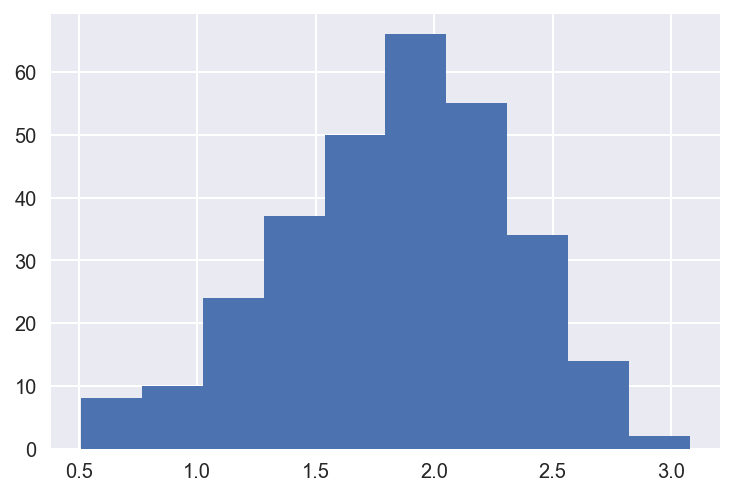

In [7]:
all_judgment_headers = ['{}_{}'.format(q_label, j_label) for 
                        q_label, j_label in itertools.product(
                            ALL_LABELS, JUDGMENT_LABELS)]
data['total_var'] = data[all_judgment_headers].std(axis=1)
plt.hist(data['total_var'])
plt.show()

# problematic = data[data.total_var < 0.75]
# problematic_judgments = problematic[all_judgment_headers]
# for index, row in problematic_judgments.iterrows():
#     print(np.unique(row))

In [8]:
data = data[data.total_var > 0.75]
print('{} eliminated'.format(sample_size - len(data)))

8 eliminated


### Simple T-Tests
We first attempt to replicate the results of the first experiment by once again conducting a paired samples t-test.

In [9]:
# Update the table with intermediate values
low_means, low_err = [], []
high_means, high_err = [], []
sample_size = len(data)

for j_label in JUDGMENT_LABELS:
    low_headers = ['{}_{}'.format(q_label, j_label) for q_label in LOW_LABELS]
    high_headers = ['{}_{}'.format(q_label, j_label) for q_label in HIGH_LABELS]
    low_data = data[low_headers].mean(axis=1)
    high_data = data[high_headers].mean(axis=1)
    
    data['{}_low'.format(j_label)] = low_data
    data['{}_high'.format(j_label)] = high_data
    data['{}_diff'.format(j_label)] = high_data - low_data
    
    low_means.append(low_data.mean())
    low_err.append(low_data.std() / math.sqrt(sample_size))
    high_means.append(high_data.mean())
    high_err.append(high_data.std() / math.sqrt(sample_size))

(1.0633553286642172, 1.4065076850344131)
Curiosity: t = -14.2, p = 5.24e-35 (1 greater)
(2.9813291196069769, 3.3762051269683657)
Popularity: t = -31.7, p = 2.41e-96 (1 greater)


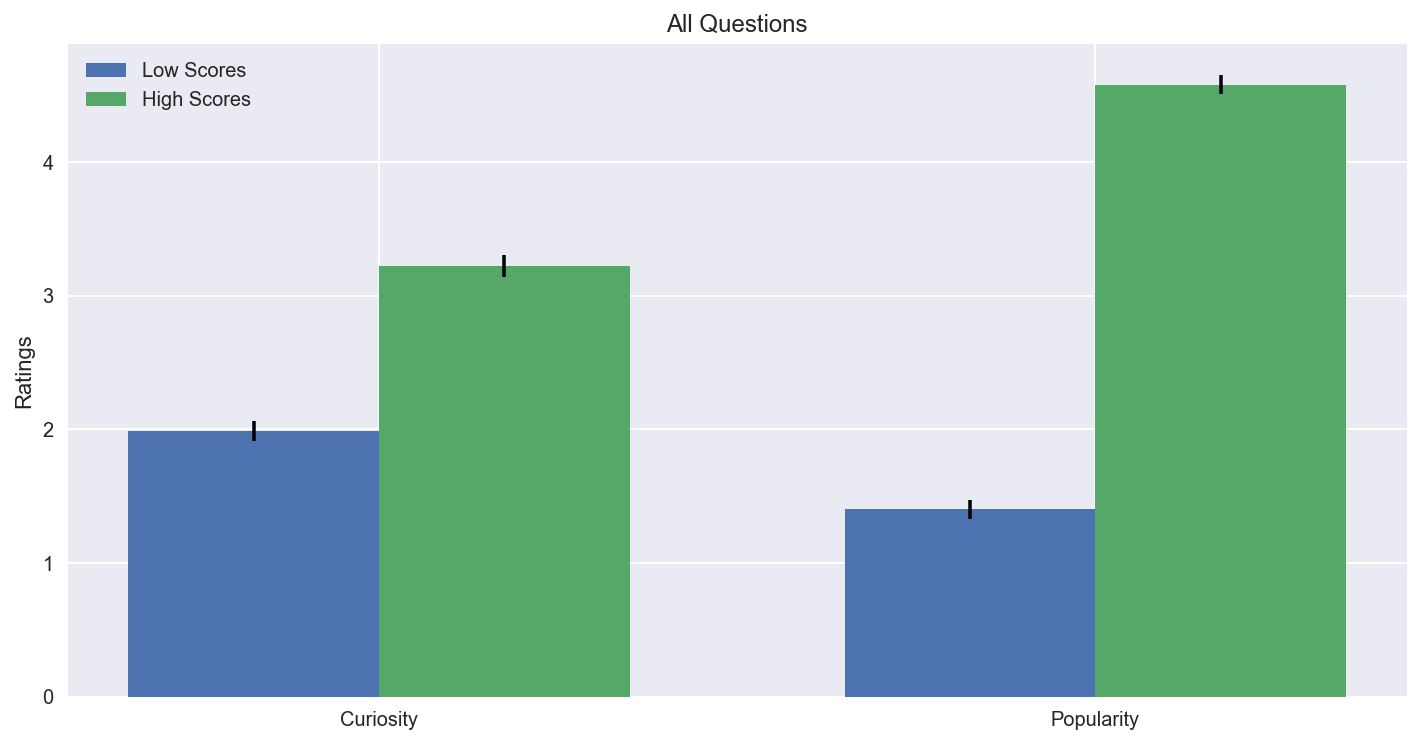

In [37]:
# Compute averages, run t-test and plot
PLOTTING_OPTIONS = {
    'y_label': 'Ratings',
    'ticks': ['Curiosity', 'Popularity'],
    'legend': ['Low Scores', 'High Scores'],
    'title': 'All Questions',
    'size': (12, 6)
}

for index, j_label in enumerate(JUDGMENT_LABELS):
    low_data = data['{}_low'.format(j_label)]
    high_data = data['{}_high'.format(j_label)]
    # print(sms.DescrStatsW(high_data - low_data).tconfint_mean())
    print('{}: {}'.format(PLOTTING_OPTIONS['ticks'][index],
              describe.paired_t_test(low_data, high_data)))

plotting.plot_double_bar(low_means, low_err, high_means,
                         high_err, **PLOTTING_OPTIONS)


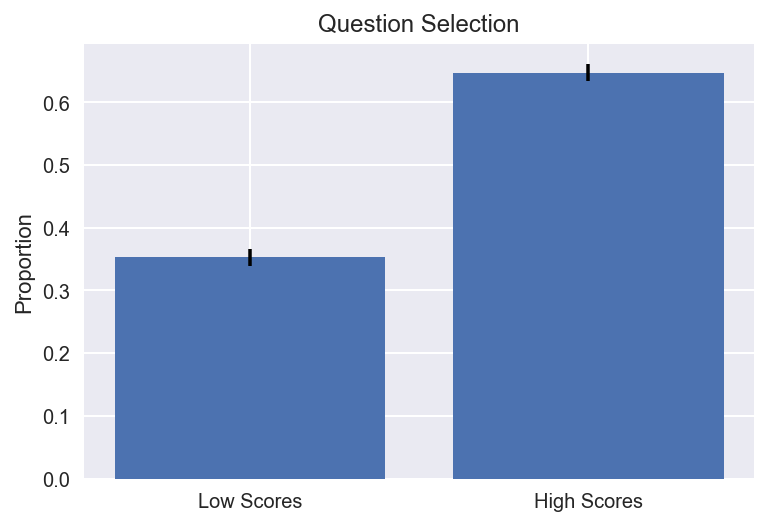

0.647260273973
t = 11.1, p = 2.87e-24 (greater)
Effect size: 0.29452054794520505


In [43]:
PLOTTING_OPTIONS = {
    'y_label': 'Proportion',
    'ticks': ['Low Scores', 'High Scores'],
    'title': 'Question Selection'
}

low_choice_labels = ['{}_choice'.format(q_label) for q_label in LOW_LABELS]
high_choice_labels = ['{}_choice'.format(q_label) for q_label in HIGH_LABELS]
low_choice_means = data[low_choice_labels].mean(axis=1)
high_choice_means = data[high_choice_labels].mean(axis=1)
low_mean = low_choice_means.mean()
high_mean = high_choice_means.mean()

plotting.plot_single_bar(
    [low_mean, high_mean],
    [low_choice_means.std() / math.sqrt(sample_size),
    high_choice_means.std() / math.sqrt(sample_size)],
    **PLOTTING_OPTIONS)

print(sms.DescrStatsW(high_choice_means).mean)
print(describe.one_sample_t_test(high_choice_means, 0.5))
print('Effect size: {}'.format(high_mean - low_mean))

### Mediation Analysis

In [12]:
# Aggreate all questions and choice
columns = ['votes', 'curiosity', 'popularity', 'choice']
flattened_data = {col: [] for col in columns}

for index, row in data.iterrows():
    for q_label in ALL_LABELS:
        level = 1 if row['{}_score'.format(q_label)] > 240.9 else 0
        flattened_data[columns[0]].append(level)
        flattened_data[columns[1]].append(row['{}_j0'.format(q_label)])
        flattened_data[columns[2]].append(row['{}_j1'.format(q_label)])
        flattened_data[columns[3]].append(row['{}_choice'.format(q_label)])

In [13]:
new_data = pd.DataFrame(flattened_data)
print(new_data.size, len(new_data))
new_data.head()

11680 2920


,choice,curiosity,popularity,votes
0,1.0,4.0,5.0,0
1,1.0,6.0,4.0,0
2,1.0,2.0,2.0,0
3,0.0,2.0,2.0,0
4,1.0,3.0,2.0,0


In [46]:
# Popularity
X = new_data['popularity']
y = new_data['choice']
X = sm.add_constant(X)

logit_model = sm.Logit(y, X)
results = logit_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.648414
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 choice   No. Observations:                 2920
Model:                          Logit   Df Residuals:                     2918
Method:                           MLE   Df Model:                            1
Date:                Tue, 30 Jan 2018   Pseudo R-squ.:                 0.06454
Time:                        21:58:23   Log-Likelihood:                -1893.4
converged:                       True   LL-Null:                       -2024.0
                                        LLR p-value:                 9.196e-59
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8609      0.067    -12.767      0.000      -0.993      -0.729
popularity     0.2879      0.018     15.597      0.000       0.252       0.324
==============================================================================
"""

In [15]:
# Curiosity
X = new_data['curiosity']
y = new_data['choice']
X = sm.add_constant(X)

logit_model = sm.Logit(y, X)
results = logit_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.591405
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 choice   No. Observations:                 2920
Model:                          Logit   Df Residuals:                     2918
Method:                           MLE   Df Model:                            1
Date:                Tue, 30 Jan 2018   Pseudo R-squ.:                  0.1468
Time:                        09:05:05   Log-Likelihood:                -1726.9
converged:                       True   LL-Null:                       -2024.0
                                        LLR p-value:                3.095e-131
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3337      0.072    -18.448      0.000      -1.475      -1.192
curiosity      0.5174      0.024     22.015      0.000       0.471       0.563
==============================================================================
"""

In [47]:
# Both
X = new_data[['popularity', 'curiosity']]
y = new_data['choice']
X = sm.add_constant(X)

logit_model = sm.Logit(y, X)
results = logit_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.586883
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 choice   No. Observations:                 2920
Model:                          Logit   Df Residuals:                     2917
Method:                           MLE   Df Model:                            2
Date:                Tue, 30 Jan 2018   Pseudo R-squ.:                  0.1533
Time:                        21:58:35   Log-Likelihood:                -1713.7
converged:                       True   LL-Null:                       -2024.0
                                        LLR p-value:                1.749e-135
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5172      0.082    -18.507      0.000      -1.678      -1.356
popularity     0.1120      0.022      5.165      0.000       0.069       0.154
curiosity      0.4590      0.026     17.807      0.000       0.408       0.510
==============================================================================
"""

In [17]:
sample_size

292